In [18]:
import pandas as pd
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [35]:
# 데이터 불러오기
train_data = pd.read_csv("~/project/MIMIC-III/Baseline/overlap/OSI/overlap_OSI(1%)_train.csv")
test_data = pd.read_csv("~/project/MIMIC-III/Baseline/overlap/OSI/overlap_OSI(1%)_test.csv")

# Overlap ARDS
ARDS = pd.read_csv("~/project/MIMIC-III/ARDS.csv")
ARDS.drop("y", axis=1, inplace=True)

train_data = pd.merge(train_data, ARDS, on=['SUBJECT_ID', 'HADM_ID'], how='inner')
test_data = pd.merge(test_data, ARDS, on=['SUBJECT_ID', 'HADM_ID'], how='inner')

train_data.drop(["SUBJECT_ID","HADM_ID", "DOA", "TLOS", "ETHNICITY"], axis=1, inplace=True)
test_data.drop(["SUBJECT_ID","HADM_ID", "DOA", "TLOS", "ETHNICITY"], axis=1, inplace=True)

train_data = pd.get_dummies(train_data, columns=["GENDER"])
test_data = pd.get_dummies(test_data, columns=["GENDER"])

# train_data와 test_data의 칼럼을 맞추기 위해 차집합을 계산
missing_columns_in_test = set(train_data.columns) - set(test_data.columns)
missing_columns_in_train = set(test_data.columns) - set(train_data.columns)

# test_data에 train_data의 더미 변수를 추가하고 0으로 채워주기
for col in missing_columns_in_test:
    test_data[col] = 0

# train_data에 test_data의 더미 변수를 추가하고 0으로 채워주기
for col in missing_columns_in_train:
    train_data[col] = 0
    
####################################################################
# Down Sampling
# train 데이터의 레이블 비율 확인
train_labels = train_data['y']
label_counts = train_labels.value_counts()

# train 데이터의 레이블 비율이 1:1이 되도록 분할
class_0_data = train_data[train_data['y'] == 0]
class_1_data = train_data[train_data['y'] == 1]

# 레이블이 0인 데이터 중에서 샘플 개수가 적은 만큼만 선택
num_samples = min(label_counts[0], label_counts[1])
class_0_data = class_0_data.sample(num_samples, random_state=42)

# 레이블이 1인 데이터 중에서 샘플 개수가 적은 만큼만 선택
class_1_data = class_1_data.sample(num_samples, random_state=42)

# 선택한 데이터를 결합하여 최종 train 데이터 생성
train_data = pd.concat([class_0_data, class_1_data])
####################################################################


# Features와 Target 설정
X_train = train_data.drop('y', axis=1)
y_train = train_data['y']
X_test = test_data.drop('y', axis=1)

print("train shape\n",X_train.shape,"\n")
print("train shape\n",X_test.shape,"\n")

target = "y"
features = [f for f in train_data.columns if f not in [target]]

print("train value\n",train_data['y'].value_counts())
print("test value\n",test_data['y'].value_counts())

train shape
 (2298, 55) 

train shape
 (1421, 55) 

train value
 0    1149
1    1149
Name: y, dtype: int64
test value
 0    1037
1     384
Name: y, dtype: int64


In [36]:
# 로지스틱 회귀 모델 학습
def objective(trial):
    c = trial.suggest_float("c", 1e-8, 10.0, log=True)
    
    model = LogisticRegression(C=c, random_state=42)
    
    # Cross Validation을 통한 평가 지표 계산
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    return scores.mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, gc_after_trial=True)

[I 2023-09-05 15:15:13,464] A new study created in memory with name: no-name-8937b7c9-b340-4c3b-9e8d-83e929b87795
[I 2023-09-05 15:15:13,674] Trial 0 finished with value: 0.6438394433528878 and parameters: {'c': 0.05244386998409367}. Best is trial 0 with value: 0.6438394433528878.
[I 2023-09-05 15:15:13,923] Trial 1 finished with value: 0.6417058592127404 and parameters: {'c': 0.0002542977143053526}. Best is trial 0 with value: 0.6438394433528878.
[I 2023-09-05 15:15:14,046] Trial 2 finished with value: 0.57347194104729 and parameters: {'c': 1.8889634884709813e-07}. Best is trial 0 with value: 0.6438394433528878.
[I 2023-09-05 15:15:14,304] Trial 3 finished with value: 0.6464267639313074 and parameters: {'c': 1.0225053696867898}. Best is trial 3 with value: 0.6464267639313074.
[I 2023-09-05 15:15:14,612] Trial 4 finished with value: 0.6468287211175758 and parameters: {'c': 1.425641891372495}. Best is trial 4 with value: 0.6468287211175758.
[I 2023-09-05 15:15:14,924] Trial 5 finished w

In [37]:
# 최적 하이퍼파라미터 확인
best_c = study.best_params["c"]

# 최적 모델 학습 및 평가
best_model = LogisticRegression(C=best_c, random_state=42)
best_model.fit(X_train, y_train)

LogisticRegression(C=0.001035499987119133, random_state=42)

Test Accuracy: 65.38
Precision: 41.26
Recall: 66.41
F1-score: 50.9


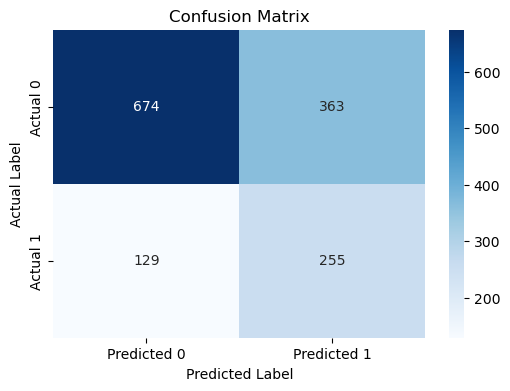

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.65      0.73      1037
           1       0.41      0.66      0.51       384

    accuracy                           0.65      1421
   macro avg       0.63      0.66      0.62      1421
weighted avg       0.72      0.65      0.67      1421



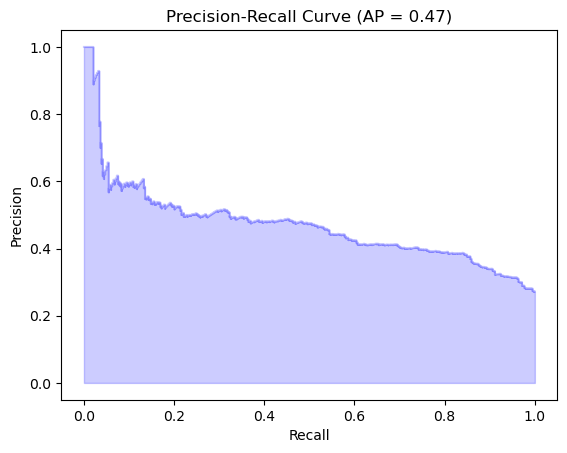

In [38]:
# Test 데이터로 모델 평가
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(test_data['y'], y_pred)
precision = precision_score(test_data['y'], y_pred)
recall = recall_score(test_data['y'], y_pred)
f1 = f1_score(test_data['y'], y_pred)

rounded_accuracy = round(accuracy * 100, 2)
rounded_precision = round(precision * 100, 2)
rounded_recall = round(recall * 100, 2)
rounded_f1 = round(f1 * 100, 2)

print("Test Accuracy:", rounded_accuracy)
print("Precision:", rounded_precision)
print("Recall:", rounded_recall)
print("F1-score:", rounded_f1)


# Confusion Matrix 계산
cm = confusion_matrix(test_data['y'], y_pred)

# Confusion Matrix 시각화
cm_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

# Classification Report 출력
print("Classification Report:")
print(classification_report(test_data['y'], y_pred))

# Precision-Recall Curve 계산 및 시각화
precision, recall, _ = precision_recall_curve(test_data['y'], best_model.predict_proba(X_test)[:, 1])
average_precision = auc(recall, precision)
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AP = {average_precision:.2f})')
plt.show()

# # Feature Importance 계산
# feature_importance = best_model.feature_importances_

# # Feature Importance 시각화
# plt.figure(figsize=(10, 6))
# sns.barplot(x=feature_importance, y=features)
# plt.title('Feature Importance')
# plt.xlabel('Importance')
# plt.ylabel('Feature')
# plt.show()